# Generalized Method of Moments (GMM) in R

In [1]:
# load packages
library(tidyverse)
library(haven) # Read and write Stata DTA files
library(gmm) # For gmm
library(nloptr)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: sandwich



## Simple Examples From the Vignettes of gmm Package

* Refer to https://cran.r-project.org/web/packages/gmm/vignettes/gmm_with_R.pdf

In [2]:
# Simulate One column data

# Reproducible
set.seed(123)
# Generate the data from normal distribution
n <- 200
x <- rnorm(n, mean = 4, sd = 2)

In [3]:
# set up the moment conditions for comparison

# MM (just identified)
g0 <- function(tet, x) {
  m1 <- (tet[1] - x)
  m2 <- (tet[2]^2 - (x - tet[1])^2)
  f <- cbind(m1, m2)
  return(f)
}

# GMM (over identified)
g1 <- function(tet, x) {
  m1 <- (tet[1] - x)
  m2 <- (tet[2]^2 - (x - tet[1])^2)
  m3 <- x^3 - tet[1] * (tet[1]^2 + 3 * tet[2]^2)
  f <- cbind(m1, m2, m3)
  return(f)
}

In [4]:
print(res0 <- gmm(g0, x, c(mu = 0, sig = 0)))

Method
 twoStep 

Objective function value:  3.513133e-06 

    mu     sig  
3.9812  1.8814  

Convergence code =  0 


In [5]:
print(res1 <- gmm(g1, x, c(mu = 0, sig = 0)))

Method
 twoStep 

Objective function value:  0.01307637 

    mu     sig  
3.8939  1.7867  

Convergence code =  0 


In [6]:
summary(res0)


Call:
gmm(g = g0, x = x, t0 = c(mu = 0, sig = 0))


Method:  twoStep 

Kernel:  Quadratic Spectral

Coefficients:
     Estimate     Std. Error   t value      Pr(>|t|)   
mu    3.9812e+00   1.2373e-01   3.2177e+01  3.7093e-227
sig   1.8814e+00   9.9904e-02   1.8832e+01   4.1605e-79

J-Test: degrees of freedom is 0 
                J-test                P-value             
Test E(g)=0:    0.000702626643691055  *******             

#############
Information related to the numerical optimization
Convergence code =  0 
Function eval. =  67 
Gradian eval. =  NA 

In [7]:
summary(res1)


Call:
gmm(g = g1, x = x, t0 = c(mu = 0, sig = 0))


Method:  twoStep 

Kernel:  Quadratic Spectral(with bw =  0.71322 )

Coefficients:
     Estimate     Std. Error   t value      Pr(>|t|)   
mu    3.8939e+00   1.2032e-01   3.2364e+01  8.9213e-230
sig   1.7867e+00   8.3472e-02   2.1405e+01  1.1937e-101

J-Test: degrees of freedom is 1 
                J-test   P-value
Test E(g)=0:    2.61527  0.10584

Initial values of the coefficients
      mu      sig 
4.022499 1.881766 

#############
Information related to the numerical optimization
Convergence code =  0 
Function eval. =  63 
Gradian eval. =  NA 

## More realistic example


* The relationship between research and development expenditures of firms and the number of patents applied and received by them has received substantial attention in the literature; see Hausman, Hall and Griliches (1984).

In [8]:
# Read the .dta
# read_dta() is in the package of `haven`, which is also part of tidyverse
# However, `haven` is not automaticcally loaded when loading tidyverse
# We need to load `haven` explicitly.

patents_df <- read_dta("patents.dta")
# explore
glimpse(patents_df)

Rows: 181
Columns: 11
$ p91      <dbl> 55, 67, 55, 83, 0, 4, 7, 0, 0, 96, 11, 39, 2, 13, 1, 42, 1, 1…
$ p90      <dbl> 80, 46, 42, 102, 1, 11, 55, 0, 1, 67, 11, 39, 3, 14, 6, 33, 1…
$ lr91     <dbl> 6.287436, 5.150736, 4.172709, 6.127538, 4.866621, 7.696947, 5…
$ lr90     <dbl> 6.16, 5.14, 4.10, 6.15, 4.82, 7.53, 5.88, 5.22, 5.56, 5.89, 5…
$ aerosp   <dbl> 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ chemist  <dbl> 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1…
$ computer <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0…
$ machines <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ vehicles <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ japan    <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ us       <dbl> 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0…


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



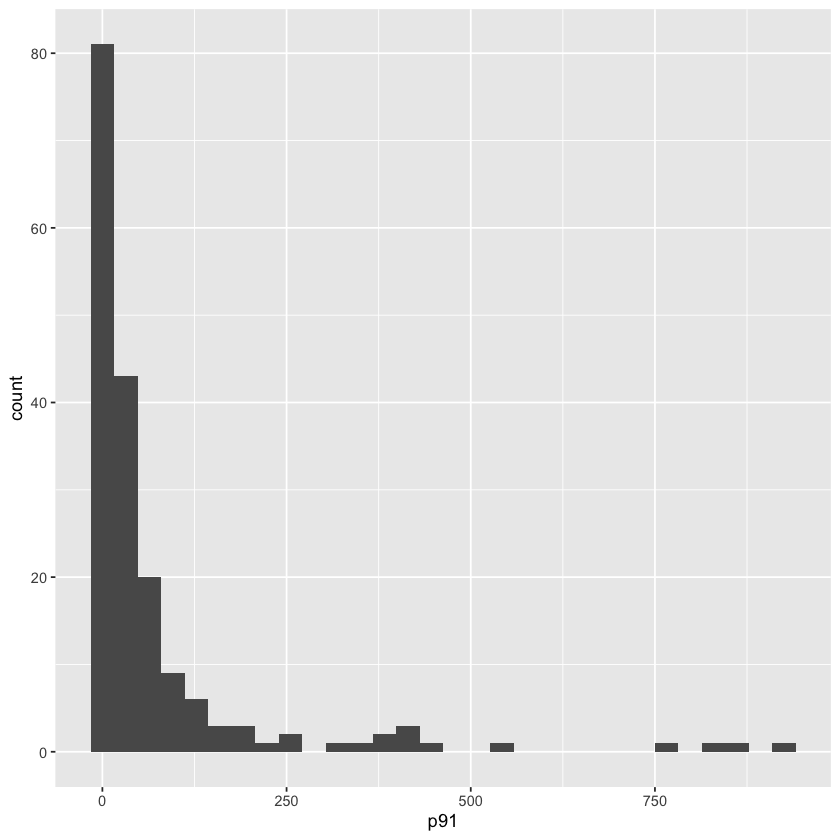

In [9]:
patents_df %>%
  ggplot(aes(p91)) %>%
  +geom_histogram()

In [10]:
# Poisson with Default standard errors (variance equals mean) based on the
# inverse of the Hessian

poisson_res <- patents_df %>%
  glm(p91 ~ lr91 + aerosp + chemist + computer + machines +
    vehicles + japan + us, family = poisson(), data = .)

summary(poisson_res)


Call:
glm(formula = p91 ~ lr91 + aerosp + chemist + computer + machines + 
    vehicles + japan + us, family = poisson(), data = .)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-27.979   -5.246   -1.572    2.352   29.246  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.873731   0.065868  -13.27  < 2e-16 ***
lr91         0.854525   0.008387  101.89  < 2e-16 ***
aerosp      -1.421850   0.095640  -14.87  < 2e-16 ***
chemist      0.636267   0.025527   24.93  < 2e-16 ***
computer     0.595343   0.023338   25.51  < 2e-16 ***
machines     0.688953   0.038346   17.97  < 2e-16 ***
vehicles    -1.529653   0.041864  -36.54  < 2e-16 ***
japan        0.222222   0.027502    8.08 6.46e-16 ***
us          -0.299507   0.025300  -11.84  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 29669.4  on 180  degrees of freedom
Residual deviance:

In [11]:
# GMM estimator as Quasi- (Psudo-) MLE
# Define moment conditions matrix for QMLE (gmm)

mom <- function(beta, df) {
  # df is the data frame with first column as dv
  # This function returns n * q matrix
  # Each column is one moment condition before taking sample average
  # There are totally q moment conditions

  y <- as.numeric(df[, 1])
  x <- data.matrix(df[, 2:ncol(df)])

  # Refer to moment conditions of QMLE
  m <- x * as.vector(y - exp(x %*% beta))

  return(cbind(m))
}

In [12]:
# Generate the data with all needed variables only
df_n <- patents_df %>%
  select(
    p91, lr91, aerosp, chemist, computer, machines,
    vehicles, japan, us
  ) %>%
  mutate(const = 1) %>%
  # Please hold the order as previous glm() to facilitate comparison
  select(
    p91, const, lr91, aerosp, chemist, computer, machines,
    vehicles, japan, us
  )

## Need to converse the tibble class to dataframe
df_n <- as.data.frame(df_n)

In [13]:
# Generate regression coef as the initial values for QMLE (gmm)
init_values <- patents_df %>%
  select(
    p91, lr91, aerosp, chemist, computer, machines,
    vehicles, japan, us
  ) %>%
  mutate(const = 1) %>%
  # Please hold the order as previous glm() to facilitate comparison
  select(
    p91, const, lr91, aerosp, chemist, computer, machines,
    vehicles, japan, us
  ) %>%
  lm(p91 ~ lr91 + aerosp + chemist + computer + machines +
    vehicles + japan + us, data = .) |>
  {\(x) coef(x)*0.01}()

In [14]:
# Be careful that we need to use "nlminb" INSTEAD OF "optim", which is
# bloody awful.
# Refer to https://cran.r-project.org/web/packages/gmm/vignettes/gmm_with_R.pdf

# Just use random initial values
set.seed(1024)
qmle_res_1 <- gmm(mom, df_n, rnorm(length(init_values)),
  wmatrix = "ident",
  optfct = "nlminb",
  control = list(eval.max = 10000)
)

In [15]:
# What about using "optimal" weight matrix
set.seed(1024)
qmle_res_1_1 <- gmm(mom, df_n, rnorm(length(init_values)),
  wmatrix = "optimal",
  optfct = "nlminb",
  control = list(eval.max = 10000)
)

In [16]:
# Use initial values from regression coef
set.seed(1024)
qmle_res_2 <- gmm(mom, df_n, init_values,
  wmatrix = "ident",
  optfct = "nlminb",
  control = list(eval.max = 10000)
)

In [17]:
# What about using "optimal" weight matrix
set.seed(1024)
qmle_res_2_2 <- gmm(mom, df_n, init_values,
  wmatrix = "optimal",
  optfct = "nlminb",
  control = list(eval.max = 10000)
)

In [18]:
summary(qmle_res_1)


Call:
gmm(g = mom, x = df_n, t0 = rnorm(length(init_values)), wmatrix = "ident", 
    optfct = "nlminb", control = list(eval.max = 10000))


Method:  One step GMM with W = identity 

Kernel:  Quadratic Spectral

Coefficients:
          Estimate     Std. Error   t value      Pr(>|t|)   
Theta[1]  -8.7373e-01   8.2369e-01  -1.0608e+00   2.8880e-01
Theta[2]   8.5453e-01   1.0396e-01   8.2195e+00   2.0441e-16
Theta[3]  -1.4219e+00   3.8728e-01  -3.6714e+00   2.4127e-04
Theta[4]   6.3627e-01   2.2535e-01   2.8234e+00   4.7514e-03
Theta[5]   5.9534e-01   3.0094e-01   1.9783e+00   4.7894e-02
Theta[6]   6.8895e-01   4.5086e-01   1.5281e+00   1.2649e-01
Theta[7]  -1.5297e+00   2.6356e-01  -5.8038e+00   6.4832e-09
Theta[8]   2.2222e-01   3.5110e-01   6.3293e-01   5.2678e-01
Theta[9]  -2.9951e-01   3.0368e-01  -9.8627e-01   3.2400e-01

J-Test: degrees of freedom is 0 
                J-test                P-value             
Test E(g)=0:    2.22284679199322e-16  *******             

##########

In [19]:
summary(qmle_res_1_1)


Call:
gmm(g = mom, x = df_n, t0 = rnorm(length(init_values)), wmatrix = "optimal", 
    optfct = "nlminb", control = list(eval.max = 10000))


Method:  twoStep 

Kernel:  Quadratic Spectral

Coefficients:
          Estimate     Std. Error   t value      Pr(>|t|)   
Theta[1]  -8.7373e-01   8.2369e-01  -1.0608e+00   2.8880e-01
Theta[2]   8.5453e-01   1.0396e-01   8.2195e+00   2.0441e-16
Theta[3]  -1.4219e+00   3.8728e-01  -3.6714e+00   2.4127e-04
Theta[4]   6.3627e-01   2.2535e-01   2.8234e+00   4.7514e-03
Theta[5]   5.9534e-01   3.0094e-01   1.9783e+00   4.7894e-02
Theta[6]   6.8895e-01   4.5086e-01   1.5281e+00   1.2649e-01
Theta[7]  -1.5297e+00   2.6356e-01  -5.8038e+00   6.4832e-09
Theta[8]   2.2222e-01   3.5110e-01   6.3293e-01   5.2678e-01
Theta[9]  -2.9951e-01   3.0368e-01  -9.8627e-01   3.2400e-01

J-Test: degrees of freedom is 0 
                J-test                P-value             
Test E(g)=0:    4.82602870693394e-15  *******             

#############
Information relat

In [20]:
summary(qmle_res_2)


Call:
gmm(g = mom, x = df_n, t0 = init_values, wmatrix = "ident", optfct = "nlminb", 
    control = list(eval.max = 10000))


Method:  One step GMM with W = identity 

Kernel:  Quadratic Spectral

Coefficients:
             Estimate     Std. Error   t value      Pr(>|t|)   
(Intercept)  -8.7373e-01   8.2369e-01  -1.0607e+00   2.8880e-01
lr91          8.5453e-01   1.0396e-01   8.2195e+00   2.0441e-16
aerosp       -1.4219e+00   3.8728e-01  -3.6714e+00   2.4127e-04
chemist       6.3627e-01   2.2535e-01   2.8234e+00   4.7514e-03
computer      5.9534e-01   3.0094e-01   1.9783e+00   4.7894e-02
machines      6.8895e-01   4.5086e-01   1.5281e+00   1.2649e-01
vehicles     -1.5297e+00   2.6356e-01  -5.8038e+00   6.4832e-09
japan         2.2222e-01   3.5110e-01   6.3293e-01   5.2678e-01
us           -2.9951e-01   3.0368e-01  -9.8627e-01   3.2400e-01

J-Test: degrees of freedom is 0 
                J-test                P-value             
Test E(g)=0:    8.12437104900666e-17  *******          

In [21]:
summary(qmle_res_2_2)


Call:
gmm(g = mom, x = df_n, t0 = init_values, wmatrix = "optimal", 
    optfct = "nlminb", control = list(eval.max = 10000))


Method:  twoStep 

Kernel:  Quadratic Spectral

Coefficients:
             Estimate     Std. Error   t value      Pr(>|t|)   
(Intercept)  -8.7373e-01   8.2369e-01  -1.0607e+00   2.8880e-01
lr91          8.5453e-01   1.0396e-01   8.2195e+00   2.0441e-16
aerosp       -1.4219e+00   3.8728e-01  -3.6714e+00   2.4127e-04
chemist       6.3627e-01   2.2535e-01   2.8234e+00   4.7514e-03
computer      5.9534e-01   3.0094e-01   1.9783e+00   4.7894e-02
machines      6.8895e-01   4.5086e-01   1.5281e+00   1.2649e-01
vehicles     -1.5297e+00   2.6356e-01  -5.8038e+00   6.4832e-09
japan         2.2222e-01   3.5110e-01   6.3293e-01   5.2678e-01
us           -2.9951e-01   3.0368e-01  -9.8627e-01   3.2400e-01

J-Test: degrees of freedom is 0 
                J-test               P-value            
Test E(g)=0:    3.5329630448637e-15  *******            

#############
Inform

* They are the same as the results from __poisson regression__.
* No matter what wegihts used for the objective function, the results are the same. The reason is that this case is just NOT GMM but MM, which means the optimum can make all sample moment conditions ZEROs. Therefore, WEIGHTS have no effects on the optimum.

## Instability Issues of `optim()`

* Here are the examples to indicate the instability issues of `optim()`

In [22]:
# Just use random initial values
set.seed(1024)
qmle_res_3 <- gmm(mom, df_n, rnorm(length(init_values)),
  wmatrix = "ident",
  optfct = "optim",
  control = list(maxit = 10000)
)

In [23]:
summary(qmle_res_3)


Call:
gmm(g = mom, x = df_n, t0 = rnorm(length(init_values)), wmatrix = "ident", 
    optfct = "optim", control = list(maxit = 10000))


Method:  One step GMM with W = identity 

Kernel:  Quadratic Spectral

Coefficients:
          Estimate     Std. Error   t value      Pr(>|t|)   
Theta[1]   4.68677922   1.41023261   3.32340862   0.00088925
Theta[2]   0.11570739   0.20325340   0.56927652   0.56916850
Theta[3]  -3.27941695   2.01337872  -1.62881276   0.10335266
Theta[4]  -0.22722767   0.35741537  -0.63575236   0.52493784
Theta[5]   0.34977317   0.31773531   1.10083191   0.27096982
Theta[6]  -1.29893740   1.45480362  -0.89286099   0.37193162
Theta[7]  -4.52432887   4.69879865  -0.96286928   0.33561313
Theta[8]   0.66823830   0.41827901   1.59758982   0.11013429
Theta[9]  -1.19538287   0.51646933  -2.31452826   0.02063876

J-Test: degrees of freedom is 0 
                J-test            P-value         
Test E(g)=0:    85.9712900801824  *******         

#############
Information rela

In [24]:
# What about anoter set of random initial values
set.seed(4201)
qmle_res_4 <- gmm(mom, df_n, rnorm(length(init_values)),
  wmatrix = "ident",
  optfct = "optim",
  control = list(maxit = 10000)
)

In [25]:
summary(qmle_res_4)


Call:
gmm(g = mom, x = df_n, t0 = rnorm(length(init_values)), wmatrix = "ident", 
    optfct = "optim", control = list(maxit = 10000))


Method:  One step GMM with W = identity 

Kernel:  Quadratic Spectral

Coefficients:
          Estimate     Std. Error   t value      Pr(>|t|)   
Theta[1]  -2.2705e+00   9.4906e-01  -2.3924e+00   1.6741e-02
Theta[2]   1.0505e+00   1.1200e-01   9.3801e+00   6.5892e-21
Theta[3]   1.2665e+00   4.2403e-01   2.9867e+00   2.8196e-03
Theta[4]   8.2098e-01   2.7830e-01   2.9500e+00   3.1782e-03
Theta[5]   1.0493e+00   3.2982e-01   3.1814e+00   1.4657e-03
Theta[6]   1.0738e+00   5.5470e-01   1.9358e+00   5.2897e-02
Theta[7]  -1.7693e+00   3.6586e-01  -4.8361e+00   1.3240e-06
Theta[8]  -1.1773e-01   3.6453e-01  -3.2296e-01   7.4673e-01
Theta[9]  -6.2103e-01   3.3889e-01  -1.8326e+00   6.6868e-02

J-Test: degrees of freedom is 0 
                J-test            P-value         
Test E(g)=0:    25.2991529223737  *******         

#############
Information rela

In [26]:
# Use initial values from regression coef
set.seed(1024)
qmle_res_5 <- gmm(mom, df_n, init_values,
  wmatrix = "ident",
  optfct = "optim",
  control = list(maxit = 10000)
)

In [27]:
summary(qmle_res_5)


Call:
gmm(g = mom, x = df_n, t0 = init_values, wmatrix = "ident", optfct = "optim", 
    control = list(maxit = 10000))


Method:  One step GMM with W = identity 

Kernel:  Quadratic Spectral

Coefficients:
             Estimate     Std. Error   t value      Pr(>|t|)   
(Intercept)  -1.5751e+00   8.6318e-01  -1.8248e+00   6.8032e-02
lr91          9.5058e-01   1.0574e-01   8.9898e+00   2.4757e-19
aerosp       -6.3890e-01   3.0844e-01  -2.0714e+00   3.8322e-02
chemist       6.9831e-01   2.2197e-01   3.1459e+00   1.6558e-03
computer      5.7561e-01   3.1042e-01   1.8543e+00   6.3699e-02
machines      8.8180e-01   3.4320e-01   2.5694e+00   1.0188e-02
vehicles     -2.6414e+00   7.0133e-01  -3.7663e+00   1.6569e-04
japan         2.2881e-01   3.5743e-01   6.4014e-01   5.2208e-01
us           -2.2998e-01   3.2465e-01  -7.0839e-01   4.7871e-01

J-Test: degrees of freedom is 0 
                J-test            P-value         
Test E(g)=0:    10.4159557668977  *******         

#############
I

## Optimization tests

In [28]:
## Set object function for gmm
eval_f <- function(beta) {
  sum(colMeans(mom(beta, df_n))^2)
}

In [29]:
## use `nloptr`, looks good.
opts <- list(
  "algorithm" = "NLOPT_LN_NELDERMEAD",
  "xtol_rel" = 1.0e-30,
  "maxeval" = 10000
)

res1 <- nloptr(
  x0 = init_values,
  eval_f = eval_f,
  opts = opts
)

res1


Call:
nloptr(x0 = init_values, eval_f = eval_f, opts = opts)


Minimization using NLopt version 2.4.2 

NLopt solver status: 4 ( NLOPT_XTOL_REACHED: Optimization stopped because 
xtol_rel or xtol_abs (above) was reached. )

Number of Iterations....: 6908 
Termination conditions:  xtol_rel: 1e-30	maxeval: 10000 
Number of inequality constraints:  0 
Number of equality constraints:    0 
Optimal value of objective function:  1.59671740340096e-24 
Optimal value of controls: -0.8737307 0.8545253 -1.42185 0.6362672 0.5953431 0.6889534 -1.529653 0.222222 
-0.2995068



In [30]:
## use `nlminb`, looks good.

res2 <- nlminb(init_values, eval_f,
  control = list(eval.max = 10000)
)

res2

$par
(Intercept)        lr91      aerosp     chemist    computer    machines 
 -0.8737307   0.8545253  -1.4218502   0.6362672   0.5953431   0.6889534 
   vehicles       japan          us 
 -1.5296528   0.2222220  -0.2995068 

$objective
[1] 1.346027e-17

$convergence
[1] 0

$iterations
[1] 53

$evaluations
function gradient 
      77      499 

$message
[1] "X-convergence (3)"

In [31]:
## use `optim`, DAMN fake convergence!

res3 <- optim(init_values, eval_f,
  method = "Nelder-Mead",
  control = list(maxit = 10000)
)

res3

$par
(Intercept)        lr91      aerosp     chemist    computer    machines 
 -1.5751145   0.9505841  -0.6388989   0.6983068   0.5756080   0.8818010 
   vehicles       japan          us 
 -2.6414034   0.2288083  -0.2299805 

$value
[1] 6.737467

$counts
function gradient 
    1318       NA 

$convergence
[1] 0

$message
NULL

## Simulation Experiments for Sampling Distribution of QMLE under Poisson and Non-Poisson Data Generation Process

In [32]:
mom <- function(beta, df) {
  # df is the data frame with first column as dv
  # This function returns n * q matrix
  # Each column is one moment condition before taking sample average
  # There are totally q moment conditions

  y <- as.numeric(df[, 1])
  x <- data.matrix(df[, 2:ncol(df)])

  # Refer to moment conditions of QMLE
  m <- x * as.vector(y - exp(x %*% beta))

  return(cbind(m))
}

In [33]:
# Let's get the repeated sets of samples and compute the corresponding QMLE
# estimates

# Now just suppose the data generation process is exactly Poisson

# set seed for reproducibility
set.seed(123)

# set the number of repeated sets of samples
nrep <- 1000

# initialize the matrix to store estimates
beta_qmle_poi <- matrix(0, nrow = nrep, ncol = 2)

# sample size
nobs <- 200
# preset beta
beta_vec <- c(0.5, -1)

In [34]:
for (i in c(1:nrep)) {
  # generate variables using random number generators
  x <- rnorm(mean = 2, sd = 1, n = nobs)
  y <- rpois(nobs, lambda = exp(beta_vec[1] + beta_vec[2] * x))
  # generate data frame
  dat <- data.frame(cbind(y, intercept = 1, x))
  qmle_res <- gmm(mom, dat, rnorm(2),
    optfct = "nlminb",
    control = list(maxit = 1000)
  )
  beta_qmle_poi[i, ] <- coef(qmle_res)
}

In [35]:
# Let's get the repeated sets of samples and compute the corresponding QMLE
# estimates

# Now just suppose the data generation process is Negative binomial
# overdispersion

# set seed for reproducibility
set.seed(123)

# set the number of repeated sets of samples
nrep <- 1000

# initialize the matrix to store estimates
beta_qmle_nb <- matrix(0, nrow = nrep, ncol = 2)

# sample size
nobs <- 200
# preset beta
beta_vec <- c(0.5, -1)

In [36]:
for (i in c(1:nrep)) {
  # generate variables using random number generators
  x <- rnorm(mean = 2, sd = 1, n = nobs)
  y <- rnbinom(nobs, mu = exp(beta_vec[1] + beta_vec[2] * x), size = 0.5)
  # generate data frame
  dat <- data.frame(cbind(y, intercept = 1, x))
  qmle_res <- gmm(mom, dat, rnorm(2),
    optfct = "nlminb",
    control = list(maxit = 1000)
  )
  beta_qmle_nb[i, ] <- coef(qmle_res)
}

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



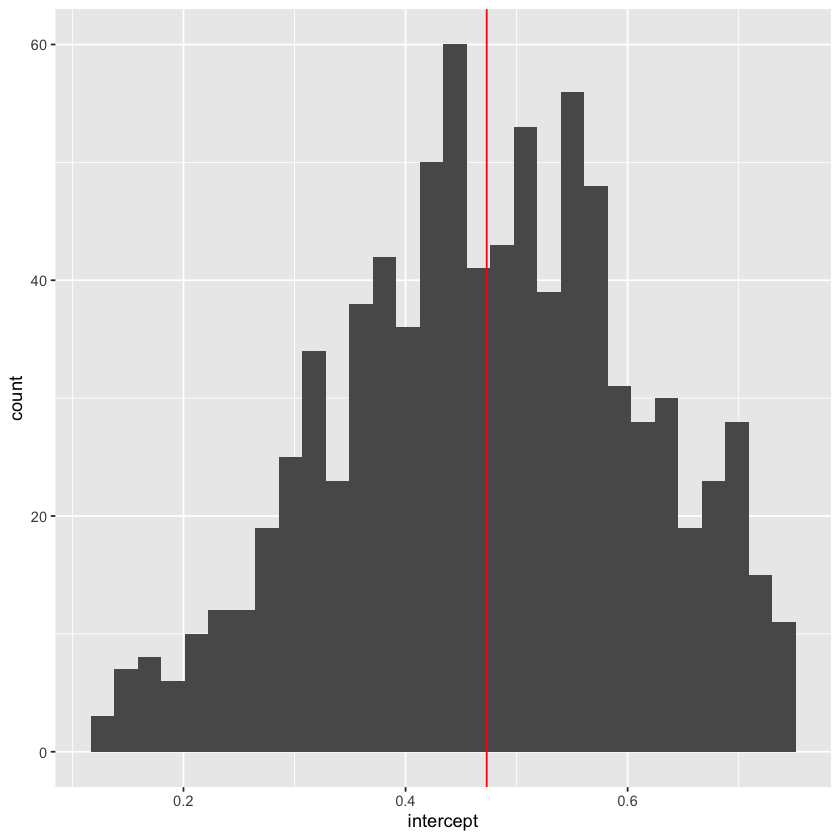

In [37]:
colnames(beta_qmle_poi) <- c("intercept", "x")

as_tibble(beta_qmle_poi) %>%
  filter(intercept > quantile(intercept, 0.05),
        intercept < quantile(intercept, 0.95),
        x > quantile(x, 0.05),
        x < quantile(x, 0.95)) %>%
  ggplot(aes(x = intercept)) +
  geom_histogram() +
  geom_vline(aes(xintercept = mean(intercept)), col = "red")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



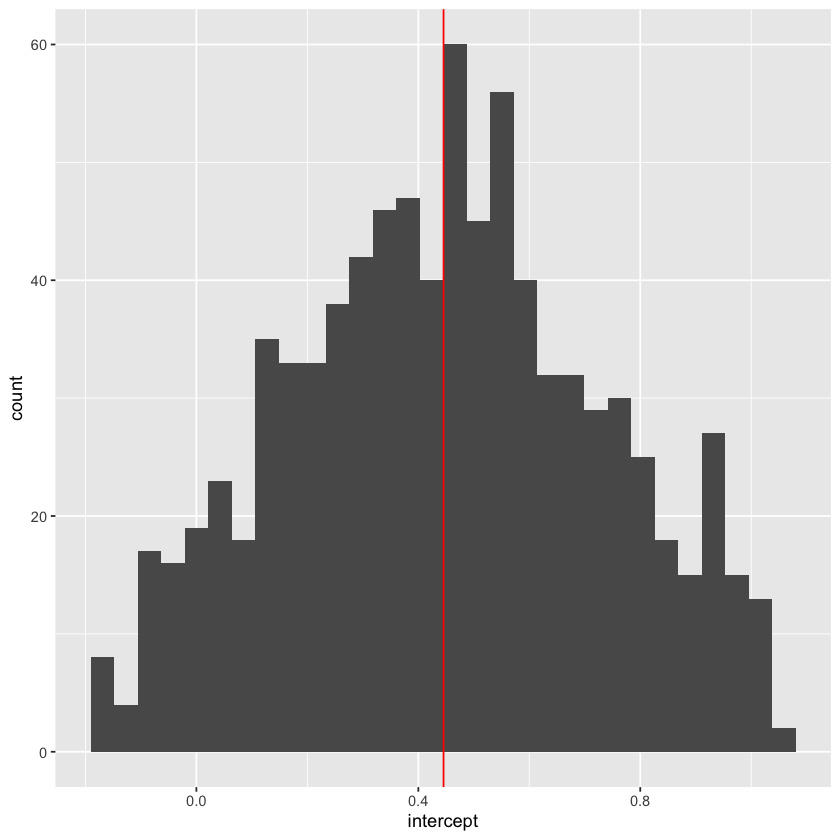

In [38]:
colnames(beta_qmle_nb) <- c("intercept", "x")

as_tibble(beta_qmle_nb) %>%
  filter(intercept > quantile(intercept, 0.05),
        intercept < quantile(intercept, 0.95),
        x > quantile(x, 0.05),
        x < quantile(x, 0.95)) %>%
  ggplot(aes(x = intercept)) +
  geom_histogram() +
  geom_vline(aes(xintercept = mean(intercept)), col = "red")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



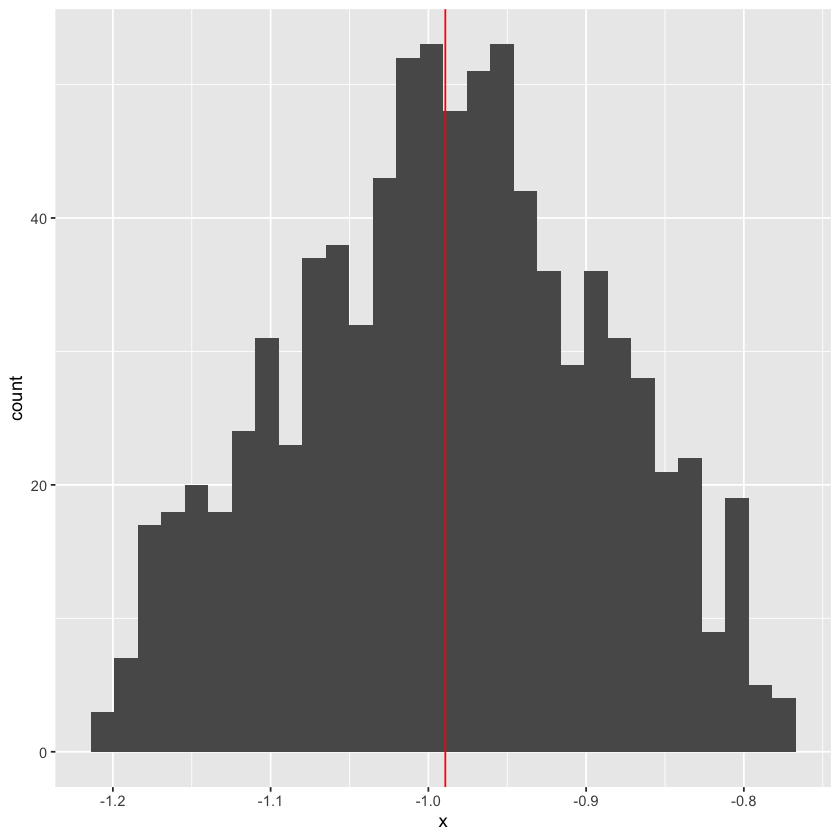

In [39]:
as_tibble(beta_qmle_poi) %>%
  filter(intercept > quantile(intercept, 0.05),
        intercept < quantile(intercept, 0.95),
        x > quantile(x, 0.05),
        x < quantile(x, 0.95)) %>%
  ggplot(aes(x = x)) +
  geom_histogram() +
  geom_vline(aes(xintercept = mean(x)), col = "red")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



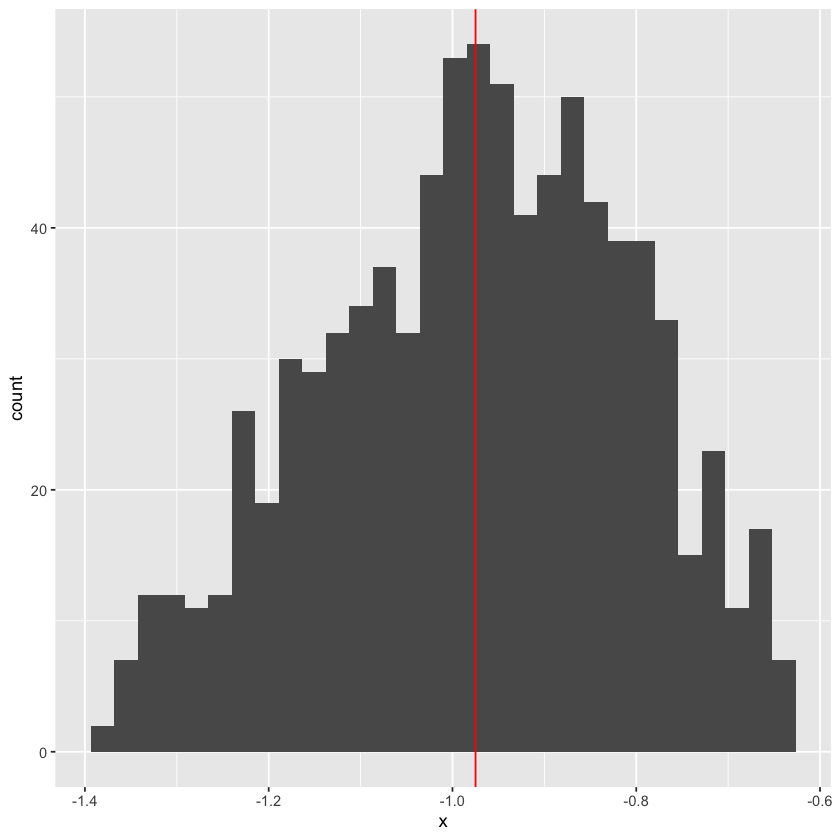

In [40]:
as_tibble(beta_qmle_nb) %>%
  filter(intercept > quantile(intercept, 0.05),
        intercept < quantile(intercept, 0.95),
        x > quantile(x, 0.05),
        x < quantile(x, 0.95)) %>%
  ggplot(aes(x = x)) +
  geom_histogram() +
  geom_vline(aes(xintercept = mean(x)), col = "red")

* GMM takes MLE (e.g. under Poisson Assumption) or OLS (i.e. MM) as the special case.

* Sampling distribution of some estimator depends on the data generation process. See the simulation experiments.

* In practice, the analysis of sampling distribution of some estimator depends on the **assumptions** on the data generation process. However, the **assumptions** usually cannot be directly verified to be correct or not. Therefore, robustness checks are usually needed. That is, indicate various results based on different **assumptions** and hope the key part of the results is consistent and robust.

In [41]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur 10.16

Matrix products: default
BLAS/LAPACK: /Users/alfredfaisam/opt/miniconda3/envs/R_4.0_mkl/lib/libmkl_rt.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] nloptr_1.2.2.2  gmm_1.6-6       sandwich_3.0-1  haven_2.4.1    
 [5] forcats_0.5.1   stringr_1.4.0   dplyr_1.0.6     purrr_0.3.4    
 [9] readr_1.4.0     tidyr_1.1.3     tibble_3.1.2    ggplot2_3.3.3  
[13] tidyverse_1.3.1

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.6        lubridate_1.7.10  lattice_0.20-44   ps_1.6.0         
 [5] zoo_1.8-9         assertthat_0.2.1  digest_0.6.27     utf8_1.2.1       
 [9] IRdisplay_1.0     R6_2.5.0          cellranger_1.1.0  repr_1.1.3       
[13] backports_1.2.1   reprex_2.0.0      evaluate_0.14     httr_1.4.2       
[1